# Synthetically Reconstructing 2-D Greyscale Penetrative Scans of Sandstone, Carbonate, and Coal using Deep Convolutional Generative Adversarial Networks

Pranav Srinivasan, Joseph Stanley, Abhiram Maddukuri, Zach Vazhekatt, Ritvik Renikunta, Atul Errabolu

## Objective

Synthetic Image Reconstruction of subsurface images is a relevant and highly useful application of existing techniques in the realm of geological analysis. Specifically, reconstruction enables a greater precision to existing morphological analysis of internal microstructures and aids uncertainty quantification and stochastic modeling by enlarging the dataset itself. Implicit structural decomposition is applied by leveraging three dimensional scans, allowing us to reconstruct from a granular level to minimize error.  Our use of porous sandstone and carbonate is due to its significant contribution to global oil and gas, as both are often trapped in the porous layers of sandstone and carbonate. Reconstruction will streamline and increase the efficacy of accessing said oil. However, these greyscale penetrative scans of porous subsurface images are very expensive to obtain and only output a limited amount of image data. With high variability in subsurface physical properties, it is imperative to have a large dataset of image data to make an accurate estimation of the subsurface properties. Thus, we can train the GANs on the distribution of actual sampled image data to augment our data and give multiple realizations to allow for more thorough and accurate analysis.
 Our ultimate goal with reconstruction is not only to expedite and enhance the holistic geological analysis of sandstone to enable, and democratize, oil and gas access to assist developing countries meet energy needs. Additionally, we wish to strengthen our predictions on subsurface data to more effectively drill energy sources and reduce the overall environmental footprint of drilling.


### Imports Section

In [ ]:
# Necessary libraries

# numpy is imported as a useful tool in combination with 
# matplotlib to perform mathematic functions and to decompose
# the shape and attributes of the images we are reconstructing
import numpy as np
# matplotlib is primarily used in the program to visualize image
# data by generating graphs. In particular, the pyplot interface
# is used to apply functions, labels, etc into our graphs, while
# the image module supports the rescaling of our grayscaled images.
import random as rd
# for random weight/pixel generation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# OpenCV implements additional features to adapt our images to 
# our model. In order to train our model and generate fabricated
# images, removing noise and decluttering the model are critical.
import cv2
#apt-get update && apt-get install -y python3-opencv run that in terminal every time 
from PIL import Image
# Allows standardization of data
from sklearn.preprocessing import StandardScaler
# Splits data into training and testing
from sklearn.model_selection import train_test_split
#allows us to get file paths from directory
import os
# importing tensorflow, the library with which we will use to build our neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model, Input
from tensorflow.keras.layers import Flatten, Dense, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## Method Descriptions

In [ ]:
# 1. generateHist(images):
# creating a gayscale(since all images are greyscale) histogram with 256 bins, each representing a color channel from [0,255]
# images = list of all the images
# Although the displayed plot is a histogram, because there are a very high amount of bins(256, each for a color value), it resembles a line graph
# Implemented as a method so that it can be called after every transformation

# 2. plot_histogram(old_image, new_image, name_1, name_2)
# we need to generate the histogram twice, but we only need to plot it once(2 histograms on a single pyplot)
# Thus, we created this method, which allows great flexibility in histogram design, for the actual plotting
# Implemented as a method so that it can be called after every transformation

# 3. parse_tif(filePath)
# reads a multi-page .tif file and returns a OpenCV image list

# 4. display_image(images, num_images_to_display)
# displays any amount of images that the user specifies

# 5. standardizeImages(images)
# standardizing all images in given list of images
# all pixels now have mean of 0 and variance of 0, following normal distribution

# 6. getAllImages(path)
# getting all PNG files from a directory path

# 7. getPNG(path)
# returns OpenCV image from path 

# 8. removeDuplicates(images)
# removing all duplicates from images, SHOULD ONLY BE RUN ONCE

# 9. generate_noise_vector()
# in order to train the generator, we need to feed an image of pure noise each time to the GAN
# this is how the GAN learns to process an image from pure noise
# the "noise" are values randomly selected from a probability distribution, in this case Gaussian

# 10. generator(image_size, num_channels, noise_vector_length, momentum, dropout, kernel_size)
# generator portion of the GAN network(details in method implementation)

# 11. discriminator(num_hidden_layers, num_channels, noise_vector_length, momentum, dropout, kernel_size, stride)
# discriminator portion of the GAN network(details in method implementation)


### Functions Section

In [ ]:
# Functions Section

def generate_hist(images, shape):
    
     #pixels is a 2d array representing the "mean" image. We calculate the mean image by summing up all the values of the images
     #at each index for each image and then dividing by the total number of images (calculated using numImages). 
     #We will use this average image to plot onthe histogram and compare distributions.
    pixels = np.zeros((shape,shape))
    
    num_images = 0

    for img in images:
        pixels += img
        num_images += 1

    #getting the "average" image 
    pixels /= num_images

    # creating a histogram, with greyscale values from 0 to 255
    histogram, bin_edges = np.histogram(pixels, bins = 256, range=(0, 255))

    #returning histogram and bin_edges objects to be used in the plot_histogram method
    return histogram, bin_edges

def plot_histogram(old_image, new_image, name_1, name_2):

    old_hist, old_bin_edges = generate_hist(old_image, old_image.shape[1])
    
    new_hist, new_bin_edges = generate_hist(new_image, new_image.shape[1])

    #calculating the integral to ensure that all pixels are represented
    old_area = np.sum(np.diff(old_bin_edges) *  (old_hist)) # should be around 250000(500 x 500)
    print("Original number of pixels: " + str(old_area))

    new_area = sum(np.diff(new_bin_edges) * new_hist) # should be around 10000(100 x 100)
    print("Original number of pixels: " + str(new_area)) #comes out to 9960.37
    
    # Creating the plot itself           
    plt.figure()    

    # Titling the plot
    plt.title("Greyscale Histogram") 

    # X label
    plt.xlabel("Bins Representing Greyscale Values from [0,255]")

    # Y label
    plt.ylabel("Number of Pixels")
    
    # plotting the histograms themselves
    plt.bar(old_bin_edges[0:-1], old_hist, label=name_1)
    plt.bar(new_bin_edges[0:-1], new_hist, label=name_2)

    plt.legend(loc = 'upper right')

    # displaying the plot
    plt.show()

def parse_tif(filePath):

    # opens the .tif file
    img = Image.open(filePath)
    lists = []
    cvImgList = []
    imgList = []
    lists.append(cvImgList)
    lists.append(imgList)

    for i in range (img.n_frames):

        # seeks the ith page of the .tif file
        img.seek(i)
        
        # converts to and OpenCV image and appends it to the image list
        cvImgList.append(np.squeeze(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)[:, :, 0]))
        imgList.append(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))
    
    return lists

def display_image(images, num_images_to_display):

    fig = plt.figure(figsize=(8, 8))

    for i in range(num_images_to_display):

        fig.add_subplot(2, 2, i + 1).set_title("Resized Image pre-Normalization" + str(i + 1))
        plt.imshow(images[i])

    plt.show()

def standardizeImages(images):
    standardized_images = []
    image_standardizers = []

    for image in images:

        scaler = StandardScaler()
        newImg = scaler.fit_transform(image)
        image_standardizers.append(scaler)
        standardized_images.append(newImg)
    
    return (standardized_images, image_standardizers)

def getAllImages(path):
    images = []

    for filename in os.listdir(path):

        if os.path.isdir(path + filename):
            #recursively calls method if path is directory
            directoryImages = getAllImages(path + filename + '/')
            
            for img in directoryImages:
                
                images.append(img)
        elif filename[-3:] == 'png':
            images.append(getPNG(path+filename))

    return images

def getPNG(path):
    return (cv2.imread(path), path)

# DO NOT RUN THIS FUNCTION AGAIN (duplicates already removed)
def removeDuplicates(images):
    # finding indexes of duplicates
    indexes = set()
    originalIndexes = set()
    for i in range(len(images)):
        for j in range(len(images)):
            if (i == j or j in originalIndexes):
                continue
            if np.array_equal(images[i][0],images[j][0]):
                indexes.add(j)
                originalIndexes.add(j)
    # deleting paths of duplicates permanently
    for num in indexes:
        os.remove(images[num][1])

def generate_noise_vector(batch_size, shape):

    # generated a vector from a normal distribution of size 100 for each row
    # doing this for all rows to generate the overall vector
    noise_batch = np.random.normal(size = [batch_size, shape])

    #pruning null values and replacing them with random values in [0,1]
    for batch in range(len(noise_vector)):
        for vector in range(len(batch)):
            if np.isnan(batch[vector]).any():
                batch[vector] = rd.random()

    # scaling to [0,1]
    noise_batch = abs(noise_batch)/np.amax(noise_batch)

    return noise_batch 

def generator(num_hidden_layers, image_size, num_channels, noise_vector_length, momentum, dropout, kernel_size):

    # initializing the filter size of the first Dense layer
    dense_init = int(image_size/(2 ** (num_hidden_layers - 1)))
    # initializing the model
    model = Sequential()

    #input layer
    #generally common practice to map to an exponent of 2 in terms of channels
    model.add(layers.Dense(dense_init * dense_init * (num_channels * (2 ** num_hidden_layers)), input_dim = noise_vector_length))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))
    model.add(layers.Reshape((dense_init, dense_init,(num_channels * (2 ** num_hidden_layers)))))
    model.add(layers.Dropout(dropout))

    #hidden layers, initializing to 3 hidden layers for simplification
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(num_channels * (2 ** (num_hidden_layers - 1)), kernel_size = kernel_size, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(num_channels * (2 ** (num_hidden_layers - 2)), kernel_size = kernel_size, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(num_channels * (2 ** (num_hidden_layers - 3)), kernel_size = kernel_size, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    model.add(layers.Conv2D(num_channels, kernel_size, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    #Final Layer
    model.add(layers.Conv2D(1, kernel_size = kernel_size))

    return model




def discriminator(num_channels, noise_vector_length, momentum, dropout, kernel_size, stride):
    # initializing the input shape coming into the discriminator as a 100 x 100 greyscale image
    input_shape  = (100, 100, 1)
    # intializing the model
    model = tf.keras.Sequential()
    
    # layer 1
    model.add(layers.Conv2D(num_channels * 2, kernel_size = kernel_size, strides = stride, input_shape = input_shape, padding = 'same'))
    model.add(layers.LeakyReLU())

    #hidden layers, initializing to 3 hidden layers for simplification
    #generally common practice to map to an exponent of 2 in terms of channels
    model.add(layers.Conv2D((num_channels * (4)), kernel_size = kernel_size, strides = stride, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    model.add(layers.Conv2D((num_channels * (8)), kernel_size, strides = stride, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    model.add(layers.Conv2D((num_channels * (16)), kernel_size, strides = stride, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    model.add(layers.Conv2D((num_channels * (32)), kernel_size, strides = stride, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization(momentum = momentum))

    # final layers
    # sigmoid output function since the task is binary classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))

    return model







### Workflow

#### 1. Image Processing, Visualization and Analysis

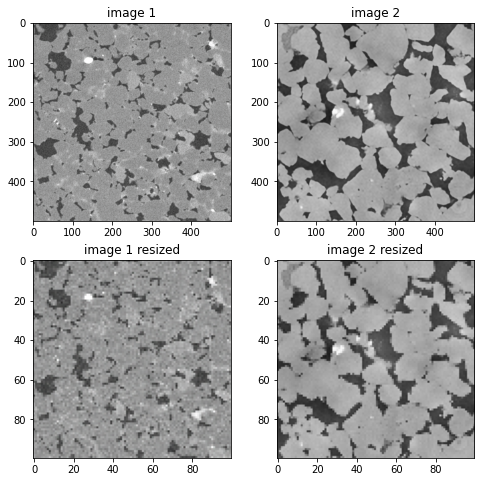

In [ ]:
# Workflow

# 1. Image Processing, Visualization and Analysis

# Here, we are reading two images as tif files.
# Because the file sizes are too large and will overload the model, we are resizing them 
# to much smaller dimensions using the resize method.
# We save these resized images into resize and resize2.
# The old images are saved into PNG and PNG2.
# Then we display these images with the imshow method.
# We display four images, the two original images and
# the two resized images.
# We use 1 2-D and 1 3-D image for greatest data representation

# 2D Image Sample
PNG = cv2.imread("/work/3201x4-sr.tif")

# 3D Image Sample
PNG2 = cv2.imread("/work/yulaiLR-SR3D.tif")

resize = cv2.resize(PNG, (100,100))
resize2 = cv2.resize(PNG2, (100, 100))
images = [(PNG, "image 1"), (PNG2, "image 2"), (resize, "image 1 resized"), (resize2, "image 2 resized")]

# Below is showing the images through matplotlib
fig = plt.figure(figsize=(8, 8))
for i in range(0, 4):
    img = images[i][0]
    fig.add_subplot(2, 2, i + 1).set_title(images[i][1])
    plt.imshow(img)
    
plt.show()

# Results below

Original number of pixels: 249023.4375
Original number of pixels: 9960.9375


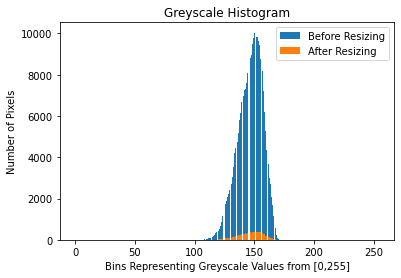

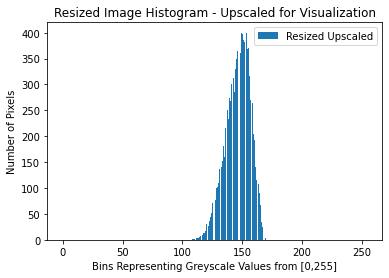

In [ ]:
# 2. Generate Histogram

# Here, we are implementing a greyscale histogram for the resize transformation
# We will not sample the entire dataset for the sake of computational efficiency - rather, we will extract 500 images to test
# The histogram will model the information loss from the resizing transform
# We will repeat the same process with normalizing the pixel values

allImages = parse_tif("/work/yulaiLR-SR3D.tif")
images = allImages[0]
images = np.array(images)

# resized_images_tr is resized_images with the extra dimensions for color channels
resized_images_tr = []
for img in allImages[1]:
    resized = cv2.resize(img, (100,100))
    resized_images_tr.append(resized)    

# resized images is the normal array of the resized pixels for the histogram
resized_images = []

#creating the resized images
for img in images:
    resized = cv2.resize(img, (100,100))
    resized_images.append(resized)

resized_images = np.array(resized_images)

#plotting the histogram of both the original and resized on a single plot
plot_histogram(images, resized_images, "Before Resizing", "After Resizing")

#plotting the histogram of the resized on its own plot to visualize the shape of the distribution
resized_hist, bins = generate_hist(resized_images, resized_images.shape[1])
       
plt.figure()    

# Titling the plot
plt.title("Resized Image Histogram - Upscaled for Visualization") 

# X label
plt.xlabel("Bins Representing Greyscale Values from [0,255]")

# Y label
plt.ylabel("Number of Pixels")

# plotting the histograms themselves
plt.bar(bins[0:-1], resized_hist, label = "Resized Upscaled")

plt.legend(loc = 'upper right')

# displaying the plot - it should almost identical, but the number of pixels should be less
plt.show()

# Results below




In [ ]:
# Loading in all of the image data
# make sure path ends with '/'

images = getAllImages("/work/DeepRockSR-2D/coal2D/")

# removing all of the duplicate images and their paths
# removeDuplicates(images) DO NOT RUN THIS AGAIN

#creating the resized images
resized_images = []
for img, path in images:
    resize = np.squeeze(img[:, :, 0])
    resize = cv2.resize(resize, (100,100))
    resized_images.append(resize)
# print("debug")
# Normalizing all of the resized images with a mean of 0 and a variance of 1

result = standardizeImages(resized_images)
standardized_images = np.array(result[0])

# scaling to [0,1]
standardized_images = abs(standardized_images)/np.amax(standardized_images)

image_scalers = result[1]

# Conducting a 80/20 train-test split
X_train, X_test = train_test_split(standardized_images, test_size = 0.2)

print("Number of images: " +  str(len(result[0])))
print("Number of train images: " +  str(len(X_train)))
print("Number of test images: " +  str(len(X_test)))

Number of images: 5757
Number of train images: 4605
Number of test images: 1152


### 2. Model Training with DCGAN

In [ ]:
img_rows = 100
img_cols = 100
channels = 1
img_shape = (img_rows, img_cols, channels)

#Given input of noise (latent) vector, the Generator produces an image.
def build_generator(): 

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define generator network 
     

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)


#building discriminator model
def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.


#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):


    half_batch = int(batch_size / 2)


#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 



    #Create noise vectors as input for generator. 
    #training generator
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size


        g_loss = combined.train_on_batch(noise, valid_y)


        #if(epoch % 10 == 0):
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        if(epoch % save_interval == 0):
            save_imgs(epoch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/work/generated_images/generatedImages" + str(epoch))
    plt.close()
#This function saves our images for us to view


optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)



print(discriminator(img))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               5120512   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 5,252,097
Trainable params: 5,252,097
Non-trainable params: 0
____________________________________________

In [ ]:
train(epochs=20000, batch_size=128, save_interval=500)

19001 [D loss: 0.129773, acc.: 96.88%] [G loss: 6.565001]
19002 [D loss: 0.111331, acc.: 96.88%] [G loss: 5.787817]
19003 [D loss: 0.042068, acc.: 99.22%] [G loss: 5.839844]
19004 [D loss: 0.099818, acc.: 95.31%] [G loss: 5.554826]
19005 [D loss: 0.027007, acc.: 100.00%] [G loss: 5.073058]
19006 [D loss: 0.090196, acc.: 96.88%] [G loss: 5.609854]
19007 [D loss: 0.063444, acc.: 96.88%] [G loss: 5.538693]
19008 [D loss: 0.032313, acc.: 100.00%] [G loss: 4.682995]
19009 [D loss: 0.107019, acc.: 96.09%] [G loss: 5.861312]
19010 [D loss: 0.107393, acc.: 95.31%] [G loss: 4.861829]
19011 [D loss: 0.084020, acc.: 96.09%] [G loss: 4.770882]
19012 [D loss: 0.048265, acc.: 97.66%] [G loss: 5.248980]
19013 [D loss: 0.075350, acc.: 99.22%] [G loss: 6.190875]
19014 [D loss: 0.038846, acc.: 98.44%] [G loss: 6.009530]
19015 [D loss: 0.118900, acc.: 96.88%] [G loss: 4.587786]
19016 [D loss: 0.080076, acc.: 96.88%] [G loss: 6.625366]
19017 [D loss: 0.268009, acc.: 92.19%] [G loss: 7.797274]
19018 [D los

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0f95b2c8-4aca-4c96-bd6d-412f443db968' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>